<a href="https://colab.research.google.com/github/abakamousa/demo_kmerai/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **MOBILE MONEY FRAUD DETECTION**

*  **What is mobile money?** Mobile money is a digital payment platform in its own right. The mobile money account acts as an electronic wallet associated with the SIM card on a user’s cellphone. The user can send and receive funds or pay for services from their cellphone without the need for a traditional bank account. They can also use registered agents to deposit cash (cash-in) or transfer funds to other accounts and receive cash in exchange (cash-out).

*   With over **$2 billion** of funds transferred every day, it’s easy to see why financial service companies such as Stripe are [investing in mobile money markets](https://stripe.com/newsroom/news/paystack-joining-stripe). They recognize the potential growth in regions such as ***sub-Saharan Africa*** where access to formal banking systems may be limited. Offering fast transactions, convenient access and secure payments, mobile money gives users instant control of their finances.

*  As this industry grows, it faces greater risks relating to mobile money fraud. In 2020, nearly [$4 billion](https://africabusinesscommunities.com/tech/tech-news/africa%E2%80%99s-mobile-fraud-losses-set-to-peak-in-2021/) was lost to fraudulent mobile money activity and scams, a figure that’s expected to grow over time as fraudsters adopt increasingly sophisticated methods.

*   The most common types of mobile money fraud involve **gaining control over a user’s cellphone** by **phishing** via voice calls (vishing) or SMS messages (smishing). Once scammers have access to the device, they may carry out SIM-swap fraud by instructing the phone service provider to transfer the number to one of their own SIM cards. [Read more](https://cambridge-intelligence.com/mobile-money-fraud/#:~:text=The%20most%20common%20types%20of,or%20SMS%20messages%20(smishing).).



 **Install librairies**

In [1]:
!pip install opendatasets
#!pip install dython

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Import librairies

In [2]:
import numpy             as np 
import pandas            as pd 
import opendatasets      as od
import seaborn           as sns
import matplotlib.pyplot as plt
import joblib


from sklearn.preprocessing     import LabelEncoder
from sklearn.ensemble          import RandomForestClassifier
from sklearn.linear_model      import SGDClassifier
from sklearn.linear_model      import LogisticRegression
from xgboost                   import XGBClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing     import RobustScaler
from imblearn.over_sampling    import SMOTE 
from sklearn.model_selection   import train_test_split, GridSearchCV
from collections               import Counter
from sklearn.pipeline          import Pipeline
from sklearn.metrics           import precision_score, accuracy_score, recall_score, f1_score
from joblib                    import dump, load
from sklearn                   import preprocessing
#from dython.nominal        import associations #for correlation analysis between categorical and continuous values

# Load dataset from kaggle

In [3]:
url="https://www.kaggle.com/datasets/ealaxi/paysim1"
od.download(url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: abakamousa
Your Kaggle Key: ··········


100%|██████████| 178M/178M [00:01<00:00, 138MB/s]


# Functions

In [4]:
def encode_df (df):
    colName = []
    for i in df.columns:
        if (df[i].dtypes == 'object'):
            colName.append(i)
    # Encode Categorical Columns
    le = LabelEncoder()
    df[colName] = df[colName].apply(le.fit_transform)
    
    return df

# Exploratory data analysis

In [5]:
df = pd.read_csv("/content/paysim1/PS_20174392719_1491204439457_log.csv")

In [ ]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0




*  step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

*    type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

*    amount - amount of the transaction in local currency.

*    nameOrig - customer who started the transaction

*    oldbalanceOrg - initial balance before the transaction

*    newbalanceOrig - new balance after the transaction

*    nameDest - customer who is the recipient of the transaction

*    oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

*    newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

*    isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control of customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

*    isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.


In [ ]:
df.describe(include='all')

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6362620,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6362620,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
unique,NaN,5,NaN,6353307,NaN,NaN,2722362,NaN,NaN,NaN,NaN
top,NaN,CASH_OUT,NaN,C1902386530,NaN,NaN,C1286084959,NaN,NaN,NaN,NaN
freq,NaN,2237500,NaN,3,NaN,NaN,113,NaN,NaN,NaN,NaN
mean,2.433972e+02,NaN,1.798619e+05,NaN,8.338831e+05,8.551137e+05,NaN,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,NaN,6.038582e+05,NaN,2.888243e+06,2.924049e+06,NaN,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,NaN,0.000000e+00,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,NaN,1.338957e+04,NaN,0.000000e+00,0.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,NaN,7.487194e+04,NaN,1.420800e+04,0.000000e+00,NaN,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,NaN,2.087215e+05,NaN,1.073152e+05,1.442584e+05,NaN,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00


In [ ]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [ ]:
df['isFraud'].value_counts(normalize=True)

0    0.998709
1    0.001291
Name: isFraud, dtype: float64

In [ ]:
df['isFlaggedFraud'].value_counts(normalize=True)

0    0.999997
1    0.000003
Name: isFlaggedFraud, dtype: float64

**Countplot of each type of transactions**

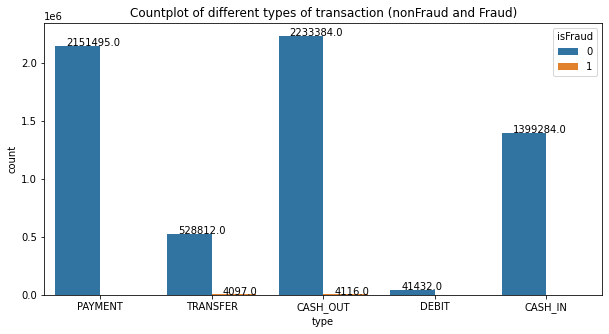

In [ ]:
plt.figure(figsize=(10,5))
ax=sns.countplot(x = "type", hue="isFraud", data = df)
plt.title('Countplot of different types of transaction (nonFraud and Fraud)')
for p in ax.patches:
  ax.annotate('{:.1f}'.format(p.get_height()), (p.get_x()+0.1, p.get_height()+50))
        

**Remarque:** pas de transaction frauduleuse pour les transactions de type PAYMENT, CASH_IN et DEBIT

**Proportion of different transactions**

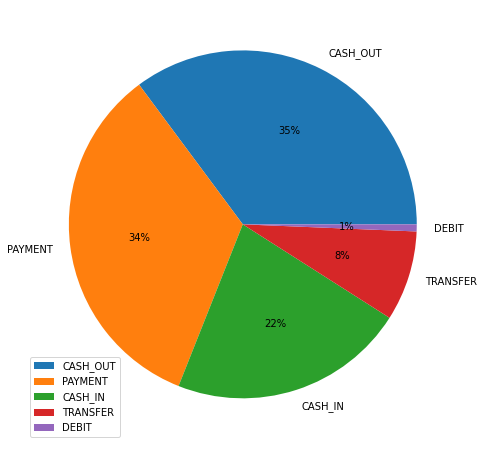

In [ ]:
type = df['type'].value_counts()
transaction = type.index
count = type.values

plt.figure(figsize=(8,8))
plt.pie(count, labels=transaction, autopct='%1.0f%%')
plt.legend(loc='lower left')
plt.show()

**Dataset splitting**

Etant donné que l'on peut rencontrer des fraudes sur des opérations de PAYMENT, CASH_IN et DEBIT, nous allons procéder à un découpage de notre jeu de données en deux:

*   Un premier jeu destiné à la réalisation de l'apprentissage non supervisé pour détecter les anomalies en prenant en compte les transactions de type PAYMENT, CASH_IN et DEBIT.
*   Un second jeu destiné à être utilisé pour réaliser un apprentissage supervisé à en prenant en compte les transactions de CASH_OUT et TRANSFER



In [6]:
df_unsupervised = df.loc[(df["type"] == "PAYMENT") | (df["type"] == "CASH_IN") | (df["type"] == "DEBIT")]
df_supervised   = df.loc[(df["type"] == "TRANSFER") | (df["type"] == "CASH_OUT")]

# **Data preparation for unsupervised ML with df_unsupervised**

#### **Data Exploration**

In [ ]:
len(df_unsupervised)

3592211

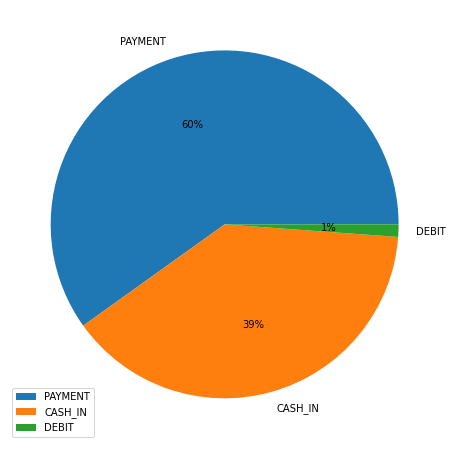

In [ ]:
type = df_unsupervised['type'].value_counts()
transaction = type.index
count = type.values

plt.figure(figsize=(8,8))
plt.pie(count, labels=transaction, autopct='%1.0f%%')
plt.legend(loc='lower left')
plt.show()

**Remarque:** Nous constatons qu'on a plus de transaction de type PAYMENT

In [ ]:
df_unsupervised['amount'].describe()

count    3.592211e+06
mean     7.368386e+04
std      1.100854e+05
min      2.000000e-02
25%      6.986600e+03
50%      1.876409e+04
75%      1.010159e+05
max      1.915268e+06
Name: amount, dtype: float64

In [ ]:
payment = df[df['type']=="PAYMENT"]
cash_in = df[df['type']=='CASH_IN']
len(payment),len(cash_in)

(2151495, 1399284)

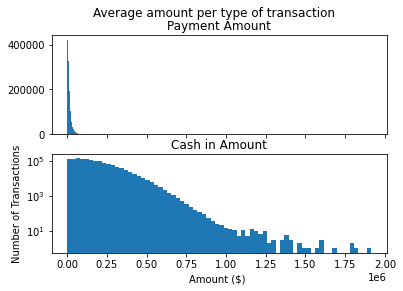

In [ ]:
graph, (plot1, plot2) = plt.subplots(2,1,sharex = True) #sharex used to avoid overlapping of titles
graph.suptitle("Average amount per type of transaction")
bins = 70

plot1.hist(payment['amount'], bins = bins)
plot1.set_title('Payment Amount')

plot2.hist(cash_in['amount'], bins = bins)
plot2.set_title('Cash in Amount')

plt.xlabel('Amount ($) ')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

**Remarque** Le montant des opérations de type PAYMENT est inférieur à celui des opérations de type CASH_IN

In [ ]:
print('Min, Max of Payment Transactions: {} - {}'.format(payment.amount.min(),payment.amount.max()))
print('Min, Max of Cash in Transactions: {} - {}'.format(cash_in.amount.min(),cash_in.amount.max()))

Min, Max of Payment Transactions: 0.02 - 238637.98
Min, Max of Cash in Transactions: 0.04 - 1915267.9


In [ ]:
df_unsupervised.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0
5,1,PAYMENT,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0,0
6,1,PAYMENT,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0,0


In [ ]:
#Vérification de la différence dans les transactions
df_unsupervised['errorBalanceOrig'] = df_unsupervised.newbalanceOrig + df_unsupervised.amount - df_unsupervised.oldbalanceOrg
df_unsupervised['errorBalanceDest'] = df_unsupervised.oldbalanceDest + df_unsupervised.amount - df_unsupervised.newbalanceDest

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
print('Percentage of transactions with non-zero \'errorBalanceOrig\'')

pd.DataFrame(df_unsupervised.groupby('type').apply(lambda df_unsupervised:len(df_unsupervised.loc[df_unsupervised.errorBalanceOrig != 0]) / len(df_unsupervised)))

Percentage of transactions with non-zero 'errorBalanceOrig'


,0
type,
CASH_IN,1.000000
DEBIT,0.329962
PAYMENT,0.594509


In [ ]:
print('Percentage of transactions with non-zero \'errorBalanceDest\'')
pd.DataFrame(df_unsupervised.groupby('type').apply(lambda df_unsupervised:len(df_unsupervised.loc[df_unsupervised.errorBalanceDest != 0]) / len(df_unsupervised)))

Percentage of transactions with non-zero 'errorBalanceDest'


,0
type,
CASH_IN,1.000000
DEBIT,0.475743
PAYMENT,1.000000


In [ ]:
df_unsupervised = df_unsupervised.drop(['isFraud','isFlaggedFraud'], axis=1)

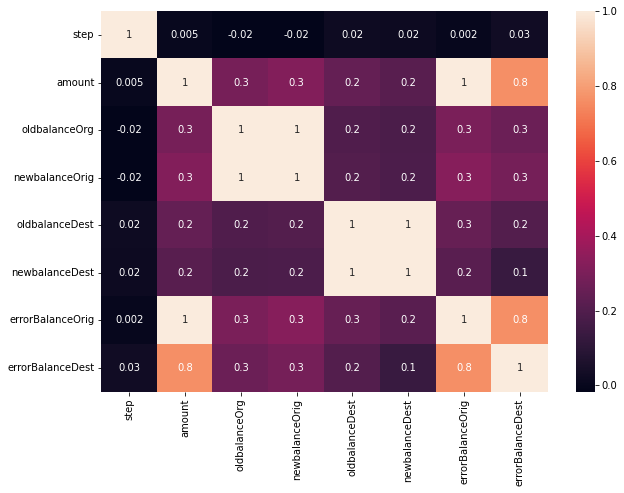

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(df_unsupervised.corr(), annot = True, fmt='.1g')

**Remarque** Les erreurs sont fortement correlés aux montant. -->

In [ ]:
#Visualisation des transaction présentant des erreurs
df_unsupervised.groupby('type').apply(lambda df_unsupervised:df_unsupervised.loc[df_unsupervised.errorBalanceDest != 0])

step     type     amount     nameOrig  oldbalanceOrg  \
type                                                                    
CASH_IN 389         1  CASH_IN  143236.26  C1862994526           0.00   
        390         1  CASH_IN  228451.89  C1614133563      143236.26   
        391         1  CASH_IN   35902.49   C839771540      371688.15   
        392         1  CASH_IN  232953.64  C1037163664      407590.65   
        393         1  CASH_IN   65912.95   C180316302      640544.28   
...               ...      ...        ...          ...            ...   
PAYMENT 6362312   718  PAYMENT    8178.01  C1213413071       11742.00   
        6362314   718  PAYMENT   17841.23  C1045048098       10182.00   
        6362316   718  PAYMENT    1022.91  C1203084509          12.00   
        6362318   718  PAYMENT    4109.57   C673558958        5521.00   
        6362319   718  PAYMENT    8634.29   C642813806      518802.00   

                 newbalanceOrig     nameDest  oldbalanceDest  newbalanceDest  \
type                                                                           
CASH_IN 389           143236.26  C1688019098       608932.17        97263.78   
        390           371688.15  C2083562754       719678.38      1186556.81   
        391           407590.65  C2001112025        49003.30            0.00   
        392           640544.28    C33524623      1172672.27      1517262.16   
        393           706457.23  C1330106945       104198.26        24044.18   
...                         ...          ...             ...             ...   
PAYMENT 6362312         3563.99  M1112540487            0.00            0.00   
        6362314            0.00  M1878955882            0.00            0.00   
        6362316            0.00   M675916850            0.00            0.00   
        6362318         1411.43  M1126011651            0.00            0.00   
        6362319       510167.71   M747723689            0.00            0.00   

                 errorBalanceOrig  errorBalanceDest  
type                                                 
CASH_IN 389             286472.52         654904.65  
        390             456903.78        -238426.54  
        391              71804.99          84905.79  
        392             465907.27        -111636.25  
        393             131825.90         146067.03  
...                           ...               ...  
PAYMENT 6362312              0.00           8178.01  
        6362314           7659.23          17841.23  
        6362316           1010.91           1022.91  
        6362318              0.00           4109.57  
        6362319              0.00           8634.29  

[3570490 rows x 11 columns]

In [ ]:
df_unsupervised.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3592211 entries, 0 to 6362323
Data columns (total 11 columns):
 #   Column            Dtype  
---  ------            -----  
 0   step              int64  
 1   type              object 
 2   amount            float64
 3   nameOrig          object 
 4   oldbalanceOrg     float64
 5   newbalanceOrig    float64
 6   nameDest          object 
 7   oldbalanceDest    float64
 8   newbalanceDest    float64
 9   errorBalanceOrig  float64
 10  errorBalanceDest  float64
dtypes: float64(7), int64(1), object(3)
memory usage: 328.9+ MB


In [ ]:
df_unsupervised.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
count,3.592211e+06,3.592211e+06,3.592211e+06,3.592211e+06,3.592211e+06,3.592211e+06,3.592211e+06,3.592211e+06
mean,2.444686e+02,7.368386e+04,1.440252e+06,1.502190e+06,6.357680e+05,5.889364e+05,1.356211e+05,1.205155e+05
std,1.428701e+02,1.100854e+05,3.725900e+06,3.763620e+06,2.489698e+06,2.472052e+06,2.260630e+05,2.529207e+05
min,1.000000e+00,2.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e-02,-5.670734e+07
25%,1.560000e+02,6.986600e+03,3.830000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.801745e+03
50%,2.490000e+02,1.876409e+04,3.334800e+04,7.089431e+04,0.000000e+00,0.000000e+00,1.245441e+04,1.905013e+04
75%,3.380000e+02,1.010159e+05,3.914786e+05,4.927196e+05,3.221801e+05,1.783475e+05,2.015790e+05,1.723466e+05
max,7.180000e+02,1.915268e+06,4.368662e+07,4.367380e+07,3.555534e+08,3.553814e+08,3.830536e+06,1.319123e+07


PAYMENT    2151495
CASH_IN    1399284
DEBIT        41432
Name: type, dtype: int64


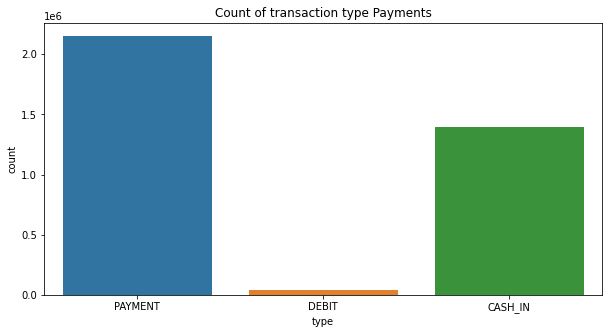

In [ ]:
#plt.figure(figsize=(10,5))
#sns.countplot(x='type',data=df_unsupervised)
#plt.title("Count of transaction type Payments")
#print(df_unsupervised.type.value_counts())

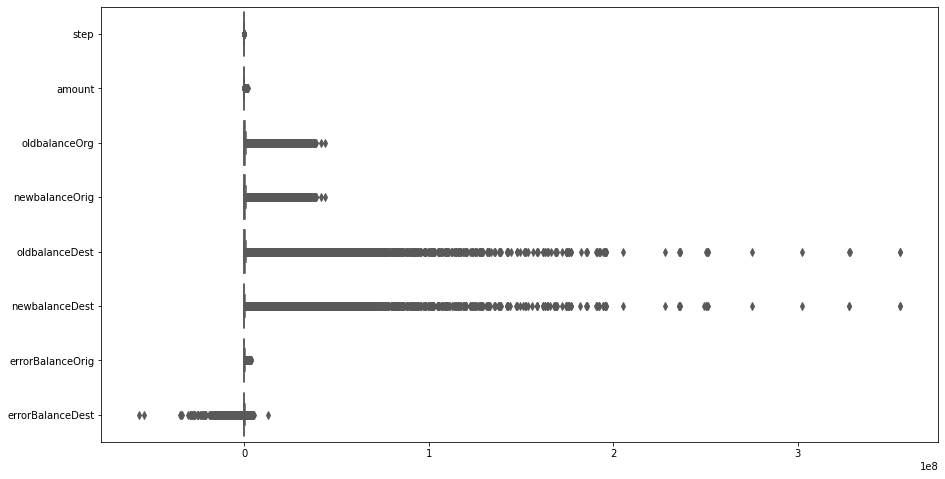

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df_unsupervised, orient="h", palette="Set2")

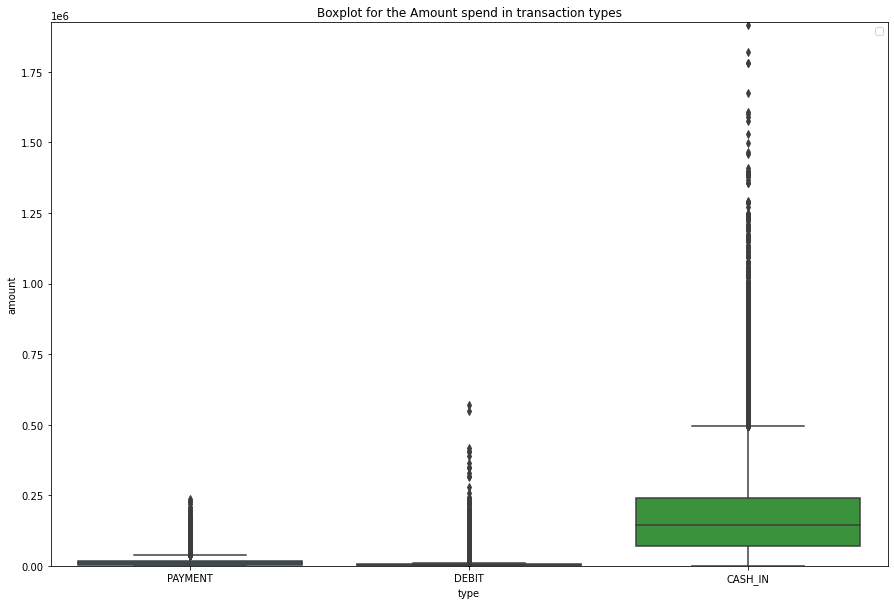

In [ ]:
# Plot histograms of the amounts in fraud and non-fraud data 
plt.figure(figsize=(15,10))
sns.boxplot(x=df_unsupervised.type,y=df_unsupervised.amount)
plt.title("Boxplot for the Amount spend in transaction types")
plt.ylim(0,max(df_unsupervised.amount)+10000)
plt.legend()
plt.show()

**Remarque:** 
* La transaction de type CASH_IN a des gros montants  
* L'on note une présente des outliers

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [7]:
#plotScatterMatrix(df_unsupervised, 20, 10)

#### **Clustering using Kmeans**

In [ ]:
#encoding
df_unsupervised['type'].replace(['CASH_IN','DEBIT','PAYMENT'],['1','2','3'], inplace=True)

In [ ]:
df_unsupervised.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
0,1,3,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0.0,9839.64
1,1,3,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0.0,1864.28
4,1,3,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0.0,11668.14
5,1,3,7817.71,C90045638,53860.0,46042.29,M573487274,0.0,0.0,0.0,7817.71
6,1,3,7107.77,C154988899,183195.0,176087.23,M408069119,0.0,0.0,0.0,7107.77


In [ ]:
#Elimination des variables non pertinante
df_unsupervised = df_unsupervised.drop(['nameOrig','nameDest'], axis=1)

In [ ]:
#standardize the data to normal distribution

df_unsupervised_standardized = preprocessing.scale(df_unsupervised)
df_unsupervised_standardized = pd.DataFrame(df_unsupervised_standardized)


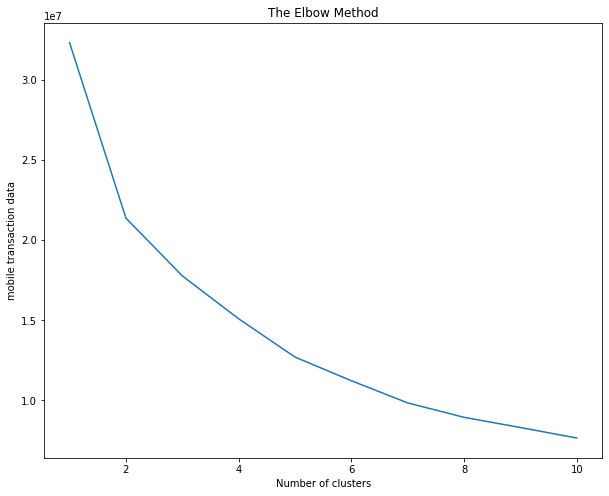

In [ ]:
# find the appropriate cluster number
plt.figure(figsize=(10, 8))
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(df_unsupervised_standardized)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('mobile transaction data')
plt.show()

To determine the optimal number of clusters,k, we have to select the value of k at the “**elbow**” i.e the point after which the distortion/inertia start decreasing in a linear fashion. Thus for the given data, we conclude that the optimal number of clusters for the data is 2. Read [more](https://blog.cambridgespark.com/how-to-determine-the-optimal-number-of-clusters-for-k-means-clustering-14f27070048f)

In [ ]:
# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters = 2, init = 'k-means++', random_state = 42)
y_kmeans = kmeans.fit_predict(df_unsupervised_standardized)
#beginning of  the cluster numbering with 1 instead of 0
y_kmeans1=y_kmeans
y_kmeans1=y_kmeans+1
# New Dataframe called cluster
cluster = pd.DataFrame(y_kmeans1)
# Adding cluster to the Dataset1
df_unsupervised['cluster'] = cluster
#Mean of clusters
kmeans_mean_cluster = pd.DataFrame(round(df_unsupervised.groupby('cluster').mean(),1))
kmeans_mean_cluster

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,errorBalanceOrig,errorBalanceDest
cluster,,,,,,,,
1.0,144.7,72701.1,1446990.5,1508901.1,587037.1,544305.9,134611.7,115432.3
2.0,144.9,73159.6,1474852.7,1537204.1,590420.8,546973.8,135511.1,116606.7


In [ ]:
df_c1 = df_unsupervised[df_unsupervised['cluster']==1.0]
df_c2 = df_unsupervised[df_unsupervised['cluster']==2.0]
#df_c3 = df_unsupervised[df_unsupervised['cluster']==3.0]
#df_c4 = df_unsupervised[df_unsupervised['cluster']==4.0]
#df_c5 = df_unsupervised[df_unsupervised['cluster']==5.0]


Visualisation du nombre d'opérations de PAYMENT par cluster

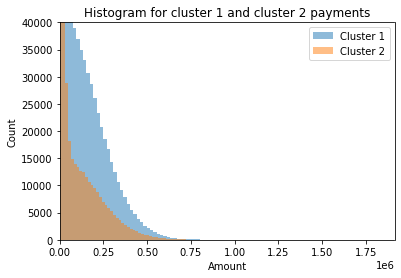

In [ ]:
plt.hist(df_c1.amount, alpha=0.5, label='Cluster 1',bins=100)
plt.hist(df_c2.amount, alpha=0.5, label='Cluster 2',bins=100)
#plt.hist(df_c3.amount, alpha=0.5, label='Cluster 3',bins=100)
#plt.hist(df_c4.amount, alpha=0.5, label='Cluster 4',bins=100)
#plt.hist(df_c5.amount, alpha=0.5, label='Cluster 5',bins=100)

plt.title("Histogram for cluster 1 and cluster 2 payments")
plt.ylim(0,40000)
plt.xlim(0,max(df_unsupervised.amount))
plt.xlabel('Amount')
plt.ylabel('Count')
plt.legend()
plt.show()

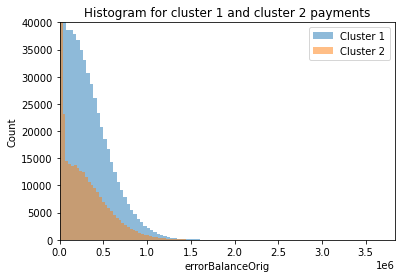

In [ ]:
plt.hist(df_c1.errorBalanceOrig, alpha=0.5, label='Cluster 1',bins=100)
plt.hist(df_c2.errorBalanceOrig, alpha=0.5, label='Cluster 2',bins=100)

plt.title("Histogram for cluster 1 and cluster 2 payments")
plt.ylim(0,40000)
plt.xlim(0,max(df_unsupervised.errorBalanceOrig))
plt.xlabel('errorBalanceOrig')
plt.ylabel('Count')
plt.legend()
plt.show()

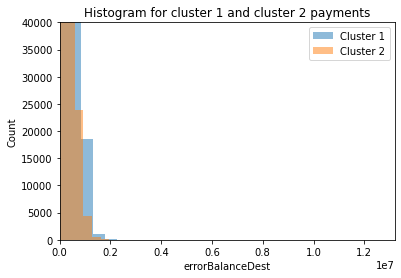

In [ ]:
plt.hist(df_c1.errorBalanceDest, alpha=0.5, label='Cluster 1',bins=100)
plt.hist(df_c2.errorBalanceDest, alpha=0.5, label='Cluster 2',bins=100)

plt.title("Histogram for cluster 1 and cluster 2 payments")
plt.ylim(0,40000)
plt.xlim(0,max(df_unsupervised.errorBalanceDest))
plt.xlabel('errorBalanceDest')
plt.ylabel('Count')
plt.legend()
plt.show()

**Note** Les données sont séparé en fonction des montants

# **Data preparation for supervised ML with df_supervised**

In [ ]:
print("Number of duplicated rows: ", df_supervised.duplicated().sum())

Number of duplicated rows:  0


In [8]:
#label encoding
df_supervised = encode_df(df_supervised)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


**Correlation analysis**

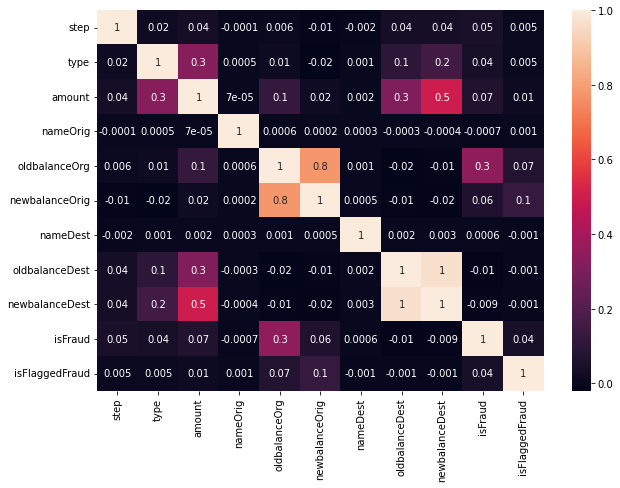

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(df_supervised.corr(), annot = True, fmt='.1g')

**Remarque:** La valeur max de corrélation entre deux variables distinctes de notre dataset est de 0.8.  

**Boxplot**

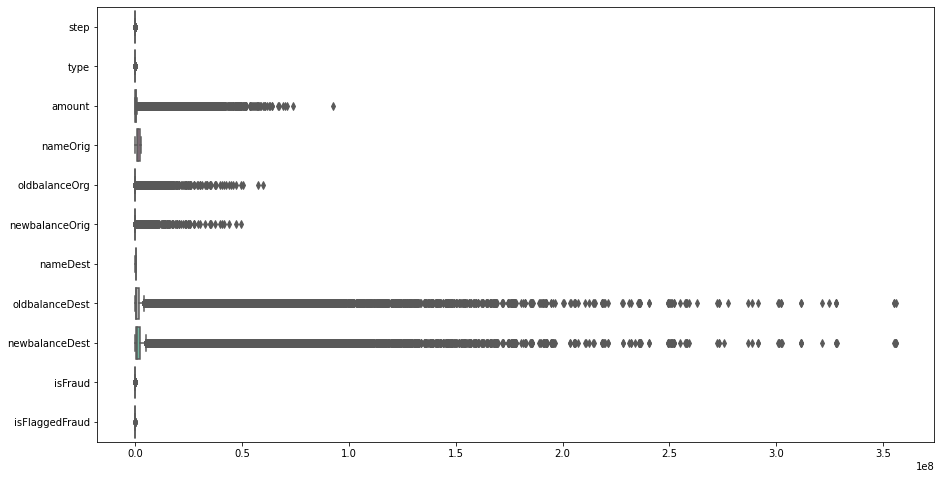

In [ ]:
plt.figure(figsize=(15,8))
sns.boxplot(data=df_supervised, orient="h", palette="Set2")

Class analysis

In [ ]:
df_supervised['isFraud'].value_counts(normalize=True)

0    0.997035
1    0.002965
Name: isFraud, dtype: float64

Remarque: 
* l'on note que les features ne sont pas à la même échelle
* l'on note la présence d'outlier --> L'on tiendra compte de cela dans le choix de la méthode de normalisation des données

**Feature scaling**

In [9]:
scaler = RobustScaler()
df_supervised_scaled = scaler.fit_transform(df_supervised)

**Train Test split**

In [10]:
feature = df_supervised_scaled[:,:-2]
target  = df_supervised_scaled[:,-2]
#feature = df_supervised.drop(['isFraud', 'isFlaggedFraud'], axis=1)
#target  = df_supervised.isFraud


In [11]:
#feature selection
new_feature = SelectKBest(f_classif, k=7).fit_transform(feature, target)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(new_feature, target, test_size=0.2)

In [16]:
#np.savetxt("test_data.csv", X_test, delimiter=",")

**Resampling**

In [ ]:
sm = SMOTE(sampling_strategy='minority', random_state=237)

X_res, y_res = sm.fit_resample(X_train, y_train)

In [ ]:
print('Resampled dataset shape %s' % Counter(y_res))

Resampled dataset shape Counter({0.0: 2209727, 1.0: 2209727})


# Prediction

In [ ]:
#models
clf1 = SGDClassifier()
clf2 = RandomForestClassifier()
clf3 = LogisticRegression()
clf4 = XGBClassifier()


**Baseline**

In [ ]:
ML_models = ['SGD', 'RF', 'LR', 'XGB']
baseline  = [clf1, clf2, clf3, clf4]
accuracy  = []
precision = []
recall = []
f1score = []


for clf in baseline :
  clf.fit(X_res, y_res)
  y_pred = clf.predict(X_test)
  accuracy.append(accuracy_score(y_test, y_pred))
  precision.append(precision_score(y_test, y_pred, average='weighted'))
  recall.append(recall_score(y_test, y_pred, average='weighted'))
  f1score.append(f1_score(y_test, y_pred, average='weighted'))

[12:36:01] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.


In [ ]:
data = {'Accuracy': accuracy, 
        'Precision': precision,
        'Recall': recall,
        'F1_score': f1score}

results = pd.DataFrame(data, index = ML_models)

In [ ]:
results

,Accuracy,Precision,Recall,F1_score
SGD,0.860683,0.996686,0.860683,0.922332
RF,0.998655,0.998932,0.998655,0.998748
LR,0.353619,0.996979,0.353619,0.518958
XGB,0.975052,0.997369,0.975052,0.985005


**Note:**  
* I order to avoid wrong prediction of fraudulent transaction, It will be necessary to choose a model with the lowest possible False Negatives rate. In fact, if the False Negative rate is too high, we will be missing a lot of crucial anomalies.
* Ideally, a well-performing model should produce both high values of precision and high values of recall. [Read more](https://towardsdatascience.com/classifying-model-outcomes-true-false-positives-negatives-177c1e702810.).
* For imbalanced datasets, the Average Precision metric is sometimes a better alternative [Read more](https://stats.stackexchange.com/questions/222558/classification-evaluation-metrics-for-highly-imbalanced-data).

In [ ]:
# save the best baseline model
filename = 'best_baseline_model.sav'
joblib.dump(clf2, filename)


['best_baseline_model.sav']

In [ ]:
loaded_model = joblib.load(filename)
result = loaded_model.predict(X_test)
print(result)

[0. 0. 0. ... 0. 0. 0.]


In [ ]:
#pipeline

pipe_SGD  = Pipeline([('scaler', scaler), ('SGD', clf1)])
pipe_RF   = Pipeline(steps=[("scaler", scaler), ("RF", clf2)]) 
pipe_LR   = Pipeline(steps=[("scaler", scaler), ("LogisticRegression", clf3)])
pipe_XGB  = Pipeline(steps=[("scaler", scaler), ("XGB", clf4)])

# Grid search

In [ ]:
#grid parameters


hyper_params_SGD = [{
'SGD__loss' : ['hinge', 'log', 'squared_hinge', 'modified_huber'],
'SGD__alpha' : [0.05, 0.1],
'SGD__penalty' : ['l2', 'l1']
}]

hyper_params_RF = [{ 
'RF__n_estimators' : [100, 200],
'RF__max_features' : ["auto", "sqrt", "log2"],
'RF__bootstrap': [True],
'RF__criterion': ['gini', 'entropy'],
'RF__oob_score': [True, False]
}]


hyper_params_LR = [{
'LogisticRegression__solver': ['newton-cg', 'sag', 'lbfgs'],
'LogisticRegression__multi_class': ['ovr', 'multinomial']
}]

hyper_params_XGB =  [{
'XGB__nthread':[4], #when use hyperthread, xgboost may become slower
'XGB__objective':['binary:logistic'],
'XGB__learning_rate': [0.05], #so called `eta` value
'XGB__max_depth': [6],
'XGB__min_child_weight': [11],
'XGB__silent': [1],
'XGB__subsample': [0.8],
'XGB__colsample_bytree': [0.7],
'XGB__n_estimators': [5], #number of trees, change it to 1000 for better results
'XGB__missing':[-999],
'XGB__seed': [1337]}]




In [ ]:
SGD_grid_search = GridSearchCV(estimator=pipe_SGD,
        param_grid=hyper_params_SGD,
        scoring='accuracy',
        n_jobs=-1,
        cv=2,
        verbose = 10)

RF_grid_search = GridSearchCV(estimator=pipe_RF,
        param_grid=hyper_params_RF,
        scoring='accuracy',
        n_jobs=-1,
        cv=2,
        verbose = 10)

LR_grid_search = GridSearchCV(estimator=pipe_LR,
        param_grid=hyper_params_LR,
        scoring='accuracy',
        n_jobs=-1,
        cv=2,
        verbose = 10)

XGB_grid_search = GridSearchCV(estimator=pipe_XGB,
        param_grid=hyper_params_XGB,
        scoring='accuracy',
        n_jobs=-1,
        cv=2,
        verbose = 10)

grids = [RF_grid_search, XGB_grid_search, LR_grid_search]

In [ ]:
#for param in XGB_grid_search.get_params().keys():
#    print(param)

In [ ]:
for pipe in grids:
    pipe.fit(X_res, y_res)

Fitting 2 folds for each of 24 candidates, totalling 48 fits


# Performance evaluation

# Inference